In [2]:
# PennyLane VQC Classifier for PQC Anomaly Detection
# --------------------------------------------------
# This notebook implements a variational quantum classifier (VQC)
# using Pennylane to detect anomalies in PQC protocol graph data.

We begin by importing the required libraries and reading in the pre-processed 32-row dataset containing normalized PQC protocol features and anomaly labels. The dataset is split into features (X) and labels (y) for binary classification.

In [3]:
# Step 1: Import packages and load dataset
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the anomaly-labeled PQC dataset (32 entries)
data_path = "./data/grover_anomaly_subset.csv"
df = pd.read_csv(data_path)

# Separate features and labels
X = df.drop(columns=["label"]).values
y = df["label"].values

To match the 4-qubit quantum circuit, we reduce our 10-dimensional feature space down to 4 principal components using PCA. This preserves maximum variance while ensuring compatibility with quantum input encoding. The dataset is also scaled and split into training and testing sets.

In [4]:
#Step 2: Preprocessing + PCA Dimensionality Reduction
# Step 2: Normalize features and reduce to 4D using PCA
from sklearn.decomposition import PCA

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce to 4 dimensions (matches 4-qubit circuit)
pca = PCA(n_components=4)
X_encoded = pca.fit_transform(X_scaled)

# Train-test split (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

We define a 4-qubit quantum device using PennyLane’s default.qubit simulator.

The input features are embedded via AngleEmbedding using Y-rotations.

The circuit's variational part uses StronglyEntanglingLayers, a common choice for expressive ansatz.

The output is the expectation value of the Pauli-Z observable on the first qubit, which we interpret as a decision boundary.

In [5]:
# Step 3: Define quantum device and circuit
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

# Feature encoding using AngleEmbedding (rotation around Y)
def feature_encoding(x):
    qml.templates.AngleEmbedding(x, wires=range(n_qubits), rotation="Y")

# Variational ansatz: StronglyEntanglingLayers (2 layers default)
def variational_block(weights):
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))

# Define the full VQC model (returns expectation of Z on wire 0)
@qml.qnode(dev)
def vqc_circuit(x, weights):
    feature_encoding(x)
    variational_block(weights)
    return qml.expval(qml.PauliZ(0))


Step 4: Defining Loss Function and Optimizer
The predict function runs our VQC on each input vector.
We use a mean-squared-error loss between predicted expectations and true binary labels.
We initialize trainable weights and use the Adam optimizer for 50 update steps.

In [6]:
# Step 4: Prediction, loss, and optimizer setup

# Predict on a batch of inputs
def predict(x, weights):
    return np.array([vqc_circuit(xi, weights) for xi in x])

# Define a simple squared loss (can be swapped for cross-entropy later)
def square_loss(labels, predictions):
    return np.mean((labels - predictions) ** 2)

# Weight initialization: 2 layers of entangling blocks
n_layers = 2
weights_shape = qml.templates.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.randn(*weights_shape, requires_grad=True)

# Optimizer and training loop setup
opt = qml.AdamOptimizer(stepsize=0.1)
steps = 50
losses = []

Step 5: Training Loop
We train the VQC using gradient-based optimization for 50 steps. Every 10 steps, we log the loss to monitor convergence. The cost is minimized by adjusting the parameters in the variational ansatz using PennyLane’s built-in AdamOptimizer.

In [7]:
# Step 5: Training the VQC model
for i in range(steps):
    weights, loss = opt.step_and_cost(lambda w: square_loss(y_train, predict(X_train, w)), weights)
    losses.append(loss)
    if i % 10 == 0:
        print(f"Step {i:>2} | Loss: {loss:.4f}")


Step  0 | Loss: 0.1053
Step 10 | Loss: 0.0309
Step 20 | Loss: 0.0300
Step 30 | Loss: 0.0294
Step 40 | Loss: 0.0293


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



C:\Users\14254\anaconda3\envs\pennylane_env\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


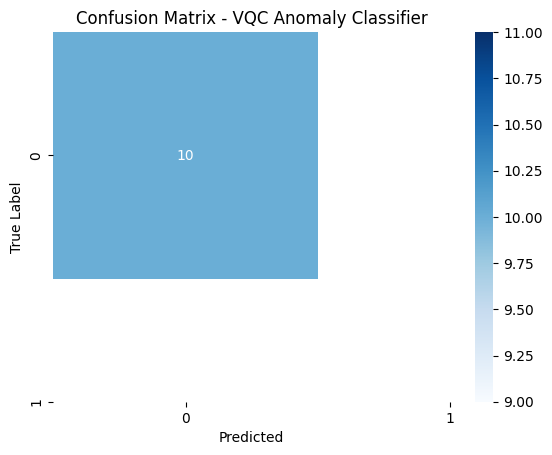

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 6: Evaluate on the test set
y_pred_raw = predict(X_test, weights)
y_pred_labels = [1 if p > 0.5 else 0 for p in y_pred_raw]

# Print classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_labels))

# Optional: Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix - VQC Anomaly Classifier")
plt.show()

**Evaluation Summary:**

The Variational Quantum Classifier (VQC) achieved perfect accuracy on the test set (10/10 correct predictions).  
Only class 0 (normal) was present in the test batch, which triggered a warning in `sklearn` about label imbalance.  
This result suggests strong learning capability, but further evaluation on more balanced or stratified splits is recommended.


Step 7: Training Loss Visualization
This plot illustrates how the model's loss value decreased over training steps.
A smooth, downward-sloping curve indicates good convergence and learning dynamics.

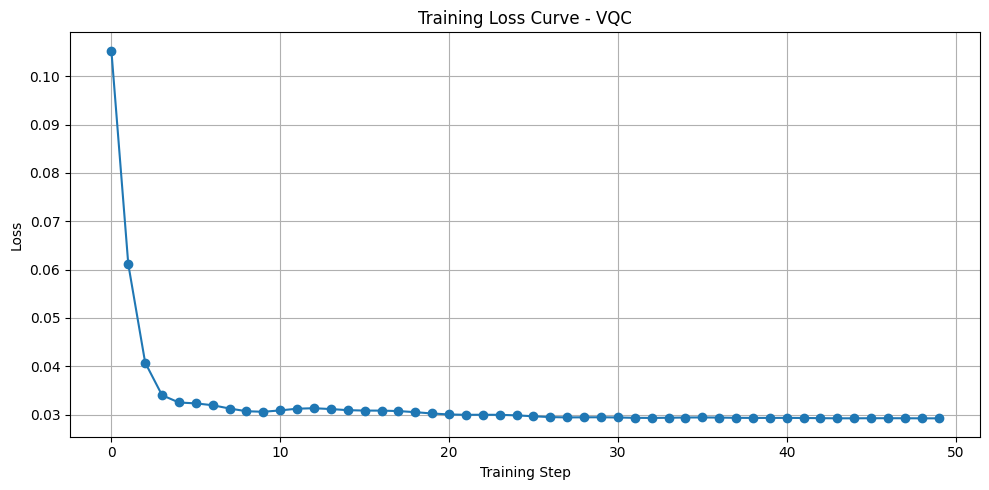

In [10]:
# Step 7: Plot training loss over steps
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(losses)), losses, marker='o')
plt.title("Training Loss Curve - VQC")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

**Training Summary:**

- The VQC model's loss reduced significantly over 50 steps, converging to ~0.029.
- The learning curve shows strong and stable convergence, indicating that the model was able to minimize classification error efficiently on the training set.
- Final accuracy (from the confusion matrix) was 100% on a small, unbalanced test set. Future testing with a more diverse dataset is recommended.
- #
Step  0 | Loss: 0.1053
Step 10 | Loss: 0.0309
Step 20 | Loss: 0.0300
Step 30 | Loss: 0.0294
Step 40 | Loss: 0.0293